In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
from mud.base import *
from mud.base import BayesProblem, DensityProblem
from mud.linear import *
from scipy.stats import gaussian_kde as kde
from scipy.stats import norm, uniform
from scipy.stats.distributions import *

%matplotlib widget

<a id='Title'></a>
# <center> Parameter Identification with Maximal Updated Densities: Existence, Uniqueness, and Convergence
_____


<center>
    Troy Butler, Michael Pilosov, and Tian Yu Yen
    <br>
</center>
    
<center>
    Notebook by:
    <br>
    Carlos del-Castillo-Negrete (<font color='blue'>cdelcastillo21@gmail.com</font>)
</center>


# Comparing Inverse Problems and Solution

This notebook is in ended to supplement [ref] section 2 covering differences in problem formulation and solutions between Bayesian and Data-Consistent Inversion. 
:set number


## Comapring Solutions Solutions

* Data-Consistent: 

    $\Large \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pred}(Q(\lambda))}$

* Bayesian:

    $\Large \pi_{post}(\lambda | d) = \frac{\pi_{prior}(\lambda)\pi_{like}(d | \lambda)}{\int_{\Lambda}\pi_{prior}(\lambda)\pi_{like}(d | \lambda)}$


Note:

* Prior density $\pi_{prior}$ represents an initial description of the epistemic, or reducible, uncertainty on $\Lambda$ in the Bayesian framework, while $\pi_{in}$ represents initial descripton of aleatoric, or irreducible, uncertainty on $\Lambda$.

* Form for Bayesian comes from Bayes rule [ref] while form for Data-Consistent comes from Disintegration theorem and Bayes rule [ref].

* The data-likelihood in the Bayesian framework, $\pi_{like}(d | \lambda)$, plays a role in the normalizing constant of the Bayesian solution, while the observed density $\pi_{ob}(Q(\lambda))$ does not in the Data-Consistent framework. 


## Example 1 - Low Dimensional Example

We start with a simple QoI map over a one-dimensional parameter space:
   
   $\Lambda = [-1, 1] \in \mathbb{R}$  
   
   $Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1]$

We will frame the Data-Consistent and Bayesian inverse problems for this particular case as similarily as possilbe, to show that even when we do so the two frameworks solve fundamentally different inverse problems.

In [5]:
def QoI(lam, p):
    """
    Defines a QoI mapping function as monomials to some power p
    """
    q = lam**p
    return q

### Data

We take $N$ samples from an initial uniform distribution over the input parameter space. These samples will be pushed forward through our QoI map to constrcut the data likelihood $\pi_{like}$ for the Bayesian framework and the predicted density $\pi_{pred}$ for the Data-Consistent Framework. 

In [6]:
seed = 123456

# Number of samples to use, and assumed observed normal distribution parameters
N, mu, sigma = int(1e3), 0.25, 0.1

# Domain of single parameter
domain = np.array([[-1, 1]])

# Get initial parameter samples - Reshape to 2D vector
lam = np.random.uniform(low=domain[0][0], high=domain[0][1], size=N).reshape(-1, 1)

# Evaluate the QoI map on this initial sample set to form predicted data - Reshape to 2D vector
q_lam = QoI(lam, 5).reshape(-1, 1)  # Evaluate lam^5 samples

# Print values
N, mu, sigma, domain, lam[0:3], q_lam[0:3]

(1000,
 0.25,
 0.1,
 array([[-1,  1]]),
 array([[-0.44077639],
        [ 0.69027808],
        [ 0.20760736]]),
 array([[-0.01663764],
        [ 0.15671856],
        [ 0.00038567]]))

### Data Consistent Approach

For the Data-Consistent framework we assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

In [7]:
# Construct density problem object using lambda samples and QoI Values
# Note by default DensityProblem class assumes uniform distribution over domain if nothing specified
# The predicted distribution will be determined from a Gaussian Kernel Density Estimate over predicted values
# Have to set observed distribution -> assuming known sample mean, 0.25, and std dev, 0.1, from observed data.
d_prob = DensityProblem(lam, q_lam, domain=domain)
d_prob.set_observed(norm(loc=mu, scale=sigma))

# Get Maximal Updated Density (MUD) point estimate
d_prob.estimate()

array([0.77269851])

### Bayesian Approach

Bayesian - Epistemic Uncertainty - Assumptions:

   For all $d \in \mathcal{D}, d = Q(\lambda^\dagger) + \xi, \xi \sim N (0,0.1^2)$
   
   $\pi_{prior} \sim \mathcal{U}([-1, 1])$
   
   Build $\pi_{post}(d | \lambda)$ assuming observed value of $d = 0.25$, leading to likelihood that matches observed distribution $N(0.25, 0.1^2)$.

In [13]:
# Construct bayesian problem object using lambda samples and QoI Values
# Fit using observed data to construct data-likelihood
bayes = BayesProblem(lam, q_lam, domain=domain)
bayes.set_likelihood(norm(loc=mu, scale=sigma))
bayes.estimate()

array([0.7597847])

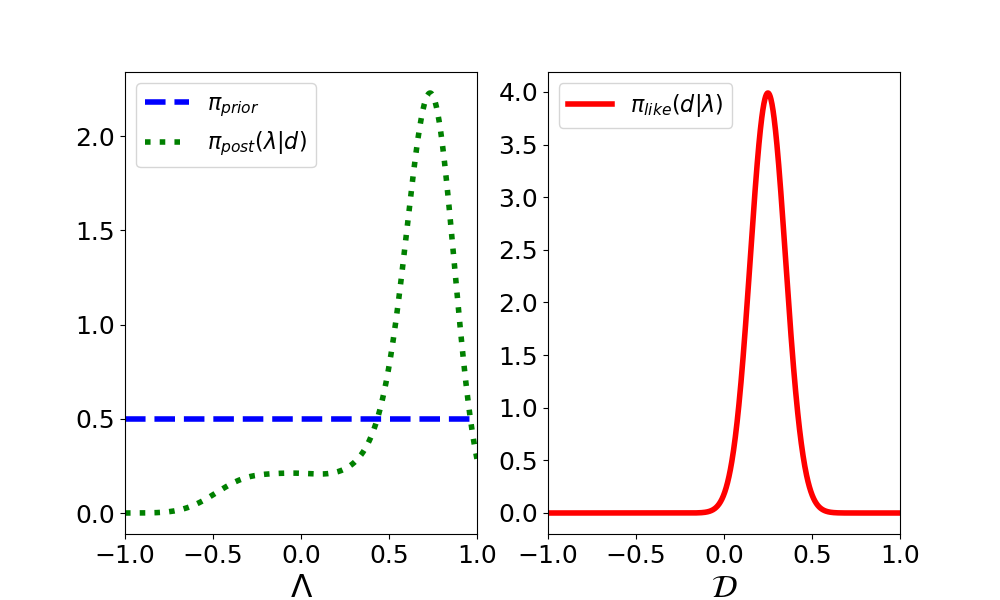

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Parameters for initial and updated plots
pr_opts = {"color": "b", "linestyle": "--", "linewidth": 4, "label": "$\\pi_{prior}$"}
ps_opts = {
    "color": "g",
    "linestyle": ":",
    "linewidth": 4,
    "label": "$\\pi_{post}(\\lambda | d)$",
}

# Plot figure to created axis - note this will solve the SIP problem
bayes.plot_param_space(ax=ax[0], pr_opts=pr_opts, ps_opts=ps_opts)

# Format figure
tick_fsize = 18
_ = ax[0].set_xlim([-1, 1])
_ = ax[0].tick_params(axis="x", labelsize=tick_fsize)
_ = ax[0].tick_params(axis="y", labelsize=tick_fsize)
_ = ax[0].set_xlabel("$\\Lambda$", fontsize=1.25 * tick_fsize)
_ = ax[0].legend(fontsize=16, loc="upper left")

# Bayes - Plot data-likelihood and and push-forward of posterior in observable space D
ll_opts = {
    "color": "r",
    "linestyle": "-",
    "linewidth": 4,
    "label": "$\\pi_{like}(d | \\lambda)$",
}
# pf_opts = {'color':'g', 'linestyle':':', 'linewidth':4, 'label':'PF of Posterior'}
bayes.plot_obs_space(ax=ax[1], ll_opts=ll_opts, pf_opts=None)

tick_fsize = 18
_ = ax[1].set_xlim([-1, 1])
_ = ax[1].tick_params(axis="x", labelsize=tick_fsize)
_ = ax[1].tick_params(axis="y", labelsize=tick_fsize)
_ = ax[1].set_xlabel("$\\mathcal{D}$", fontsize=1.25 * tick_fsize)
_ = ax[1].legend(fontsize=16, loc="upper left")

### Comparison Plots

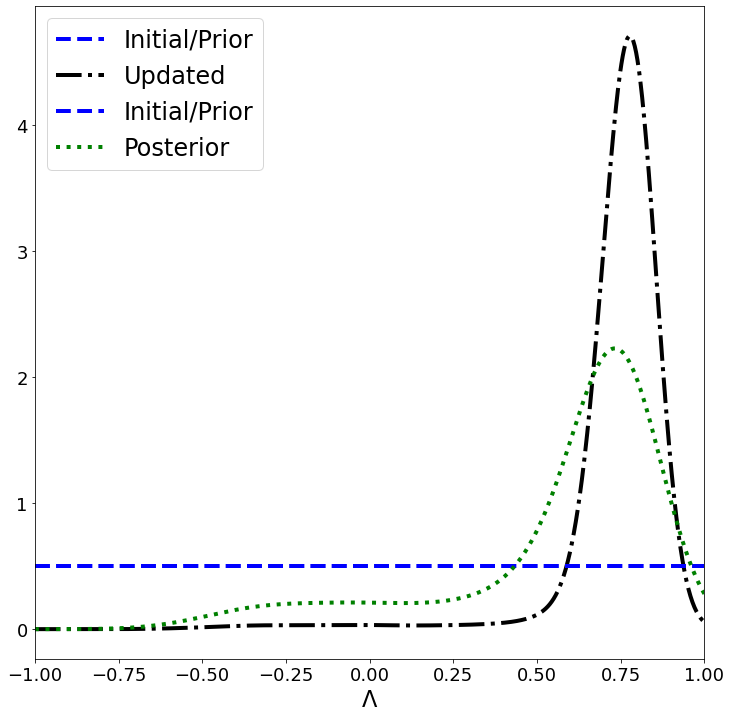

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))

# Parameters for initial and updated plots
in_opts = {"color": "b", "linestyle": "--", "linewidth": 4, "label": "Initial/Prior"}
up_opts = {"color": "k", "linestyle": "-.", "linewidth": 4, "label": "Updated"}
ps_opts = {"color": "g", "linestyle": ":", "linewidth": 4, "label": "Posterior"}

# Plot figure to created axis - note this will solve the SIP problem
d_prob.plot_param_space(ax=ax, in_opts=in_opts, up_opts=up_opts, win_opts=None)
bayes.plot_param_space(ax=ax, pr_opts=in_opts, ps_opts=ps_opts)

# Format figure
tick_fsize = 18
_ = ax.set_xlim([-1, 1])
_ = ax.tick_params(axis="x", labelsize=tick_fsize)
_ = ax.tick_params(axis="y", labelsize=tick_fsize)
_ = ax.set_xlabel("$\\Lambda$", fontsize=1.25 * tick_fsize)
_ = ax.legend(fontsize=24, loc="upper left")

NameError: name 'bayes' is not defined

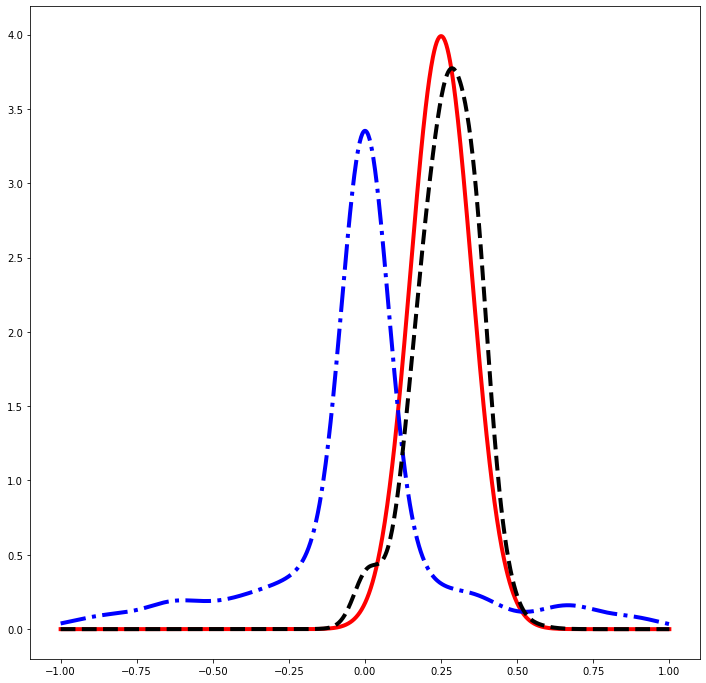

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))


# DCI - Plot predicted and pushforward of initial in observable space D
pr_opts = {"color": "b", "linestyle": "-.", "linewidth": 4, "label": "PF of Initial"}
pf_opts = {"color": "k", "linestyle": "--", "linewidth": 4, "label": "PF of Updated"}
d_prob.plot_obs_space(ax=ax, pr_opts=pr_opts, pf_opts=pf_opts)

# Bayes - Plot data-likelihood and and push-forward of posterior in observable space D
ll_opts = {"color": "r", "linestyle": "-", "linewidth": 4, "label": "$N(0.25,0.1^2)$"}
pf_opts = {"color": "g", "linestyle": ":", "linewidth": 4, "label": "PF of Posterior"}
bayes.plot_obs_space(ax=ax, ll_opts=ll_opts, pf_opts=pf_opts)

# Format figure
tick_fsize = 18
_ = ax.set_xlim([-1, 1])
_ = ax.tick_params(axis="x", labelsize=tick_fsize)
_ = ax.tick_params(axis="y", labelsize=tick_fsize)
_ = ax.set_xlabel("$\\mathcal{D}$", fontsize=1.25 * tick_fsize)
_ = ax.legend(fontsize=24, loc="upper left")

# Linear Theory of MUD points

This notebook is intended to supplement [ref] section 3 on the linear theory of Maximal Updated Density points. 

## Example 2 - Linear Gaussian Problem

In this section we assume linear (or affine) QoI maps with Gaussian distributions and compare the analytical solutions given by the Bayesian and Data-Consistent Framework:

$Q(\lambda) = A\lambda + \mathbf{b}, A \in \mathbb{R}^{d\times p}$,

For the Bayesian framework, assume 

$\pi_{prior} = \mathcal{N}(\lambda_0,\Sigma_{init}), \pi_{obs} = \mathcal{N}({\bf y}, \Sigma_{obs})$.

Our analytical MAP point is given by (eq. ref in paper):

$\lambda^{MAP} = \lambda_0 + \Sigma_{post}A^T\Sigma_{obs}^{-1}(\mathbf{y} - \mathbf{b} - A\lambda_0), 
 \Sigma_{post} := (A^T\Sigma_{obs}^{-1}A + \Sigma_{init}^{-1})^{-1}$

For the Data-Consistent framework, assume

$\pi_{in} = \mathcal{N}(\lambda_0,\Sigma_{init}), \pi_{obs} = \mathcal{N}({\bf y}, \Sigma_{obs})$.

Our analytical MUD point is given by (eq. ref in paper):

$\lambda^{MUD} = \lambda_0 + \Sigma_{init}A^T\Sigma_{pred}^{-1}(\mathbf{y} - \mathbf{b} - A\lambda_0), 
 \Sigma_{pred} := A\Sigma_{init}A^T$


Problem Set-Up:

$A = \begin{bmatrix} 1 & 1 \end{bmatrix}, b = 0, y = 1$

$\lambda_0 = \begin{bmatrix} 0.25 & 0.25 \end{bmatrix}^T,
\Sigma_{init} = \begin{bmatrix} 1 & -0.25 \\ -0.25 & 0.5 \end{bmatrix},
\Sigma_{obs} = \begin{bmatrix} 0.25 \end{bmatrix}$

In [3]:
ex_2 = LinearGaussianProblem(
    A=np.array([[1, 1]]),
    b=np.array([[0]]),
    y=np.array([[1]]),
    mean_i=np.array([[0.25, 0.25]]).T,
    cov_i=np.array([[1, -0.25], [-0.25, 0.5]]),
    cov_o=np.array([[1]]),
)
ex_2.solve("mud"), ex_2.solve("map"), ex_2.solve("ls")

(array([[0.625],
        [0.375]]),
 array([[0.4375],
        [0.3125]]),
 array([[0.5],
        [0.5]]))

### Comparing Functionals

1. Bayesian - Tikhonov regularization - Traditional solution, searching for value that minimizes residual but also without blowing up solution. 

$\Large T(\lambda) := || Q(\lambda) - \mathbf{y} || ^2_{\Sigma^{-1}_{obs}} + || \lambda-\lambda_0 || ^2_{\Sigma_{init}^{-1}}$

2. Data-Consistent - An extra term from Tikhanov reg, coming from the predicted density, to "unregularize" in drections that are informed by the data. So if large discrepancy between data and observations, term will be large.

$\Large J(\lambda) := T(\lambda) - || Q(\lambda) - Q(\lambda_0) || ^2_{\Sigma^{-1}_{pred}}$


In [1]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot contour map for data mismatch term
ex_2.plot_fun_contours(ax=ax, terms="data", levels=50, cmap=cm.viridis, alpha=1.0)

# Plot solution contour for 2-1 map, going through least squares solution as the reference point.
ex_2.plot_contours(
    ax=ax,
    annotate=True,
    note_loc=[0.1, 0.9],
    label="Solution Contour",
    plot_opts={"color": "r"},
    annotate_opts={"fontsize": 20, "backgroundcolor": "w"},
)

# Plot initial mean point
ex_2.plot_sol(
    ax=ax,
    point="initial",
    pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
)
ax.axis("equal")

_ = ax.set_title("Data Mismatch $||Q(\lambda) - y||^2$", fontsize=24)
_ = ax.set_xlim([0, 1])
_ = ax.set_ylim([0, 1])

NameError: name 'plt' is not defined

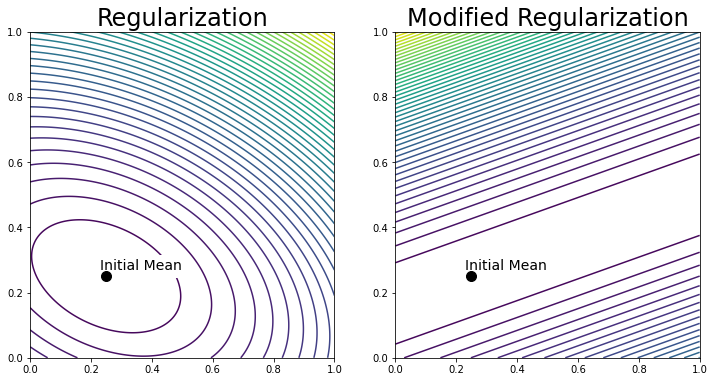

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot contour map for Tikhonov regularization term
ex_2.plot_fun_contours(ax=ax[0], terms="reg", levels=50, cmap=cm.viridis, alpha=1.0)

# Plot initial mean point
ex_2.plot_sol(
    ax=ax[0],
    point="initial",
    label="Initial Mean",
    pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
)

_ = ax[0].set_title("Regularization", fontsize=24)

# Plot contour map for modified Tikhanov regularization term
ex_2.plot_fun_contours(ax=ax[1], terms="reg_m", levels=50, cmap=cm.viridis, alpha=1.0)

# Plot initial mean point
ex_2.plot_sol(
    ax=ax[1],
    point="initial",
    label="Initial Mean",
    pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
)

_ = ax[1].set_title("Modified Regularization", fontsize=24)

_ = ax[0].axis([0, 1, 0, 1])
_ = ax[1].axis([0, 1, 0, 1])

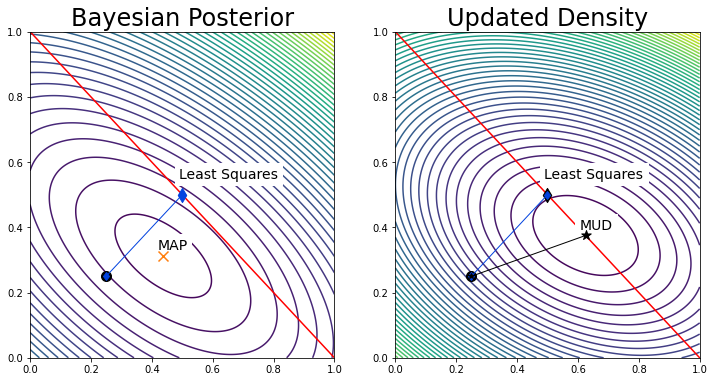

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot contour map for functional for Bayesian Posteriror
ex_2.plot_fun_contours(ax=ax[0], terms="bayes", levels=50, cmap=cm.viridis)

# Plot initial mean point
ex_2.plot_sol(
    ax=ax[0],
    point="initial",
    pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
)

# Plot Least Squares Solution
ex_2.plot_sol(
    ax=ax[0],
    point="ls",
    label="Least Squares",
    note_loc=[0.49, 0.55],
    pt_opts={"color": "xkcd:blue", "s": 100, "marker": "d", "zorder": 10},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot MAP Solution
ex_2.plot_sol(
    ax=ax[0],
    point="map",
    label="MAP",
    pt_opts={"color": "tab:orange", "s": 100, "marker": "x", "zorder": 10},
    ln_opts=None,
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot solution contour for 2-1 map, going through least squares solution as the reference point.
ex_2.plot_contours(
    ax=ax[0],
    annotate=False,
    note_loc=[0.1, 0.9],
    label="Solution Contour",
    plot_opts={"color": "r"},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

_ = ax[0].set_title("Bayesian Posterior", fontsize=24)
_ = ax[0].axis([0, 1, 0, 1])

# Plot contour map for functional for Updated Density
ex_2.plot_fun_contours(ax=ax[1], terms="dc", levels=50, cmap=cm.viridis)

# Plot initial mean point
ex_2.plot_sol(
    ax=ax[1],
    point="initial",
    pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
)

# Plot Least Squares Solution and line from initial to it
ex_2.plot_sol(
    ax=ax[1],
    point="ls",
    label="Least Squares",
    note_loc=[0.49, 0.55],
    pt_opts={"color": "k", "s": 100, "marker": "d", "zorder": 10},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot MUD Solution
ex_2.plot_sol(
    point="mud",
    ax=ax[1],
    label="MUD",
    pt_opts={"color": "k", "s": 100, "marker": "*", "zorder": 10},
    ln_opts={"color": "k", "marker": "*", "lw": 1, "zorder": 10},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot solution contour for 2-1 map, going through least squares solution as the reference point.
ex_2.plot_contours(
    ax=ax[1],
    annotate=False,
    note_loc=[0.1, 0.9],
    label="Solution Contour",
    plot_opts={"color": "r"},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

_ = ax[1].set_title("Updated Density", fontsize=24)
_ = ax[1].axis([0, 1, 0, 1])

In [6]:
ex_3 = LinearGaussianProblem(
    A=np.array([[1, 1]]),
    b=np.array([[0]]),
    y=np.array([[1]]),
    mean_i=np.array([[0.25, 0.25]]).T,
    cov_i=np.array([[1, -0.5], [-0.5, 0.5]]),
    cov_o=np.array([[0.5]]),
    alpha=1.0,
)

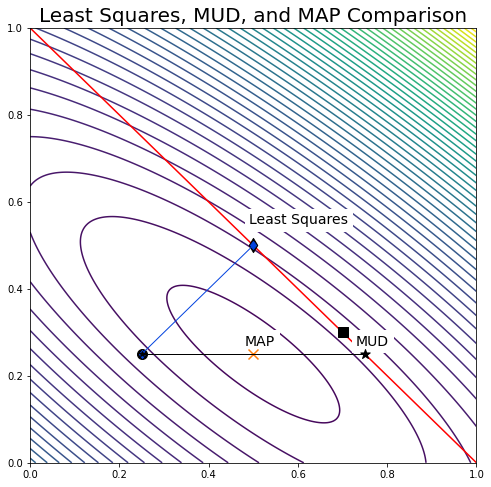

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot contour map for functional for Updated Density
ex_3.plot_fun_contours(ax=ax, terms="bayes", levels=50, cmap=cm.viridis)

# Plot initial mean point
ex_3.plot_sol(
    ax=ax,
    point="initial",
    pt_opts={"color": "k", "s": 100, "marker": "o", "label": "MUD", "zorder": 10},
)

# Plot Least Squares Solution and line from initial to it
ex_3.plot_sol(
    ax=ax,
    point="ls",
    label="Least Squares",
    note_loc=[0.49, 0.55],
    pt_opts={"color": "k", "s": 100, "marker": "d", "zorder": 10},
)

# Plot MAP Solution
ex_3.plot_sol(
    ax=ax,
    point="map",
    label="MAP",
    pt_opts={"color": "tab:orange", "s": 100, "marker": "x", "zorder": 10},
    ln_opts=None,
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot MUD Solution
ex_3.plot_sol(
    point="mud",
    ax=ax,
    label="MUD",
    pt_opts={"color": "k", "s": 100, "marker": "*", "zorder": 10},
    ln_opts={"color": "k", "marker": "*", "lw": 1, "zorder": 10},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot solution contour for 2-1 map, going through least squares solution as the reference point.
ex_3.plot_contours(
    ax=ax,
    annotate=False,
    note_loc=[0.1, 0.9],
    label="Solution Contour",
    plot_opts={"color": "r"},
    annotate_opts={"fontsize": 14, "backgroundcolor": "w"},
)

# Plot "Reference" parameter
ax.scatter([0.7], [0.3], color="k", s=100, marker="s", zorder=11)

_ = ax.set_title("Least Squares, MUD, and MAP Comparison", fontsize=20)
_ = ax.axis([0, 1, 0, 1])

# Higher-Dimensional Linear Gaussian Examples

This notebook is intended to supplement [ref] section 4 on numerical comparisons of MUD, MAP, and Least Squares solutions to the Linear Gaussian problem as the dimension of the problem increases. 


In [9]:
# dim_output = dim_input
alpha_list = [1.0, 0.1, 0.001]
dim_input, dim_output = 100, 100
seed = 21

# Construct random inputs drawn from standard normal
A = np.random.randn(dim_output, dim_input)
b = np.random.randn(dim_output).reshape(-1, 1)
lam_ref = np.random.randn(dim_input).reshape(-1, 1)
y = A @ lam_ref + b

# Initial guess at mean is just origin
mean_i = np.zeros(dim_input).reshape(-1, 1)

# Initial Covariance drawn from standard normal centerred at 0.5
cov_i = np.diag(np.sort(np.random.rand(dim_input))[::-1] + 0.5)

randn_high_dim = LinearGaussianProblem(A, b, y, mean_i, cov_i)

In [10]:
# Build list of rank k updates of A A_ranks = []
rank_1_updates = []
u, s, v = np.linalg.svd(A)
A_ranks.append(s[0] * (u[:, 0].reshape(-1, 1)) @ v[:, 0].reshape(1, -1))
for i in range(1, dim_output):
    rank_1_updates.append(s[i] * (u[:, i].reshape(-1, 1)) @ v[:, i].reshape(1, -1))
    A_ranks.append(sum(rank_1_updates[0:i]))

In [11]:
c = np.linalg.norm(lam_ref)
err = lambda xs: [np.linalg.norm(x - lam_ref) / c for x in xs]

dim_errs = []
rank_errs = []
for alpha in alpha_list:
    r_errs = []
    d_errs = []
    randn_high_dim.alpha = alpha
    for dim in range(1, dim_output + 1, 1):
        # Solve inverse problem for dimensional subset problem
        # Tuple is returned, with (mud, map, least-squares) solutions
        dim_solutions = randn_high_dim.solve(method="all", output_dim=dim)

        # Construct Rank k Linear Problem
        y_rank = A_ranks[dim - 1] @ lam_ref + b
        rank_prob = LinearGaussianProblem(
            A_ranks[dim - 1], b, y_rank, mean_i, cov_i, alpha=alpha
        )
        rank_solutions = rank_prob.solve(method="all")

        # Compute errors
        d_errs.append(np.array(err(dim_solutions)))
        r_errs.append(np.array(err(rank_solutions)))

    dim_errs.append(np.array(d_errs))
    rank_errs.append(np.array(r_errs))

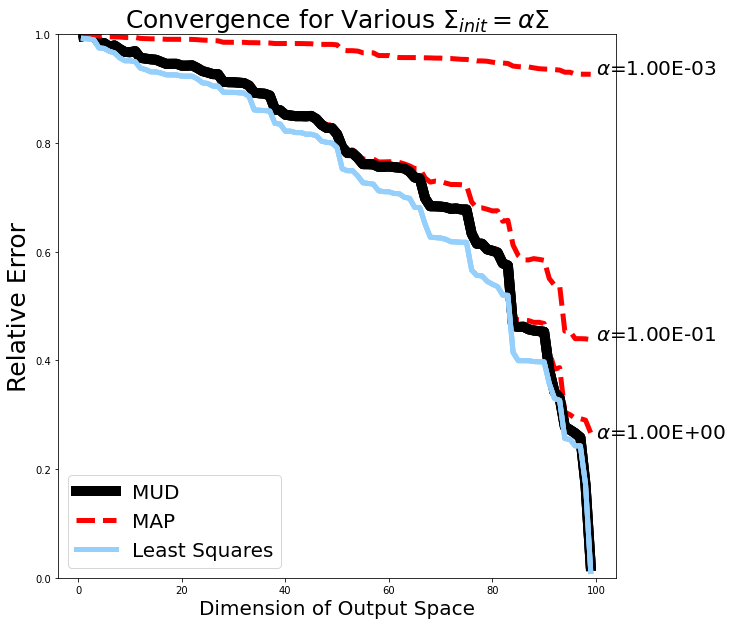

In [13]:
fsize = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

x = np.arange(1, dim_output, 1)

for idx, alpha in enumerate(alpha_list):
    # Plot convergence for MUD Solutions
    ax.plot(x, dim_errs[idx][:, 0][:-1], label="MUD", c="k", lw=10)

    # Plot convergence plot for MAP Solutions - Annotate for different alphas
    ax.plot(x, dim_errs[idx][:, 1][:-1], label="MAP", c="r", ls="--", lw=5)
    ax.annotate(
        f"$\\alpha$={alpha:1.2E}",
        (100, max(dim_errs[idx][:, 1][-1], 0.01)),
        fontsize=fsize,
    )

    # Plot convergence for Least Squares Solutions
    ax.plot(
        x,
        dim_errs[idx][:, 2][:-1],
        label="LSQ",
        c="xkcd:light blue",
        ls="-",
        lw=5,
        zorder=10,
    )

# Label plot
_ = ax.set_title(
    "Convergence for Various $\\Sigma_{init} = \\alpha \\Sigma$", fontsize=1.25 * fsize
)
_ = ax.set_ylim(0, 1.0)
_ = ax.set_ylabel("Relative Error", fontsize=fsize * 1.25)
_ = ax.set_xlabel("Dimension of Output Space", fontsize=fsize)
_ = ax.legend(["MUD", "MAP", "Least Squares"], fontsize=fsize)

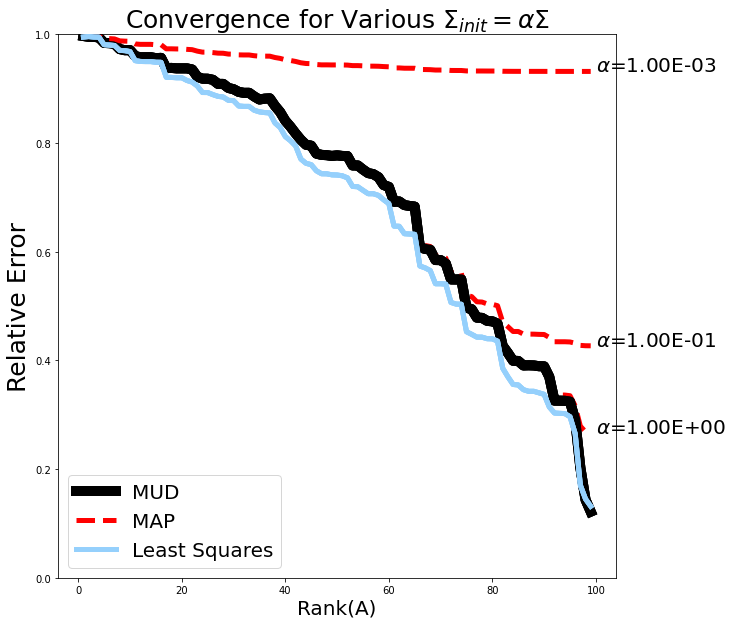

In [14]:
fsize = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

x = np.arange(1, dim_output, 1)

for idx, alpha in enumerate(alpha_list):
    # Plot convergence for MUD Solutions
    ax.plot(x, rank_errs[idx][:, 0][:-1], label="MUD", c="k", lw=10)

    # Plot convergence plot for MAP Solutions - Annotate for different alphas
    ax.plot(x, rank_errs[idx][:, 1][:-1], label="MAP", c="r", ls="--", lw=5)
    ax.annotate(
        f"$\\alpha$={alpha:1.2E}",
        (100, max(rank_errs[idx][:, 1][-1], 0.01)),
        fontsize=fsize,
    )

    # Plot convergence for Least Squares Solutions
    ax.plot(
        x,
        rank_errs[idx][:, 2][:-1],
        label="LSQ",
        c="xkcd:light blue",
        ls="-",
        lw=5,
        zorder=10,
    )

# Label plot
_ = ax.set_title(
    "Convergence for Various $\\Sigma_{init} = \\alpha \\Sigma$", fontsize=1.25 * fsize
)
_ = ax.set_ylim(0, 1.0)
_ = ax.set_ylabel("Relative Error", fontsize=fsize * 1.25)
_ = ax.set_xlabel("Rank(A)", fontsize=fsize)
_ = ax.legend(["MUD", "MAP", "Least Squares"], fontsize=fsize)

In [2]:
# For reproducibility of results in paper. Can comment out
seed = 123456

# Data-Constructed QoI Maps 

This notebook is intended to supplement [ref] section 5 where data-constructed Quantity of Interest (QoI) Maps are explored.

## Notation and Assumptions

Assuming $d$ measurement devices for which repeated noisy data are obtained, let:

* $\mathcal{M}_j(\lambda^\dagger) = $ the $j$th measurement device, for each $1\leq j\leq d$.

* $N_j = $ the number of noisy data obtained for each device.

* $d_{j,i} = $ the $i$th noisy datume from $j$th measurement device, where $1\leq i \leq N_j$. 

Assuming unbiased additive error model for the measurement noise with i.i.d. Gaussian errors, we have:
    
$d_{j,i} = \mathcal{M}_j(\lambda^\dagger) + \xi_i, \xi_i \sim N(0,\sigma_j^2), 1\leq i \leq N_j$

## Illustrative Example

Returning to problem from section 2:

   $\Lambda = [-1, 1] \in \mathbb{R}$  
   
   $Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1]$


In [3]:
def QoI(lam, p):
    """
    Defines a QoI mapping function as monomials to some power p
    """
    q = lam**p
    return q


# Number of samples to use, and assumed observed normal distribution parameters
N, mu, sigma = int(1e3), 0.25, 0.1

# Domain of single parameter
domain = np.array([[-1, 1]])

# Get initial parameter samples - Reshape to 2D vector
np.random.seed(21)  # For reproducibility of paper results, comment out if desired.
lam = np.random.uniform(low=domain[0][0], high=domain[0][1], size=N).reshape(-1, 1)

# Evaluate the QoI map on this initial sample set to form predicted data - Reshape to 2D vector
q_lam = QoI(lam, 5).reshape(-1, 1)

### Incoroporating Observed Data

Before, we only talked about how predicted data pushed through a model is used to solve the Bayesian and Stochastic Inversion Problems. For the Bayesian Inversion problem, it is clear that osberved data are used to construct the data-likelihood function $\pi_{post}(\lambda|d)$. The question now becomes how do we incorporate real observed data within the SIP framework. Before, in the SIP
 
For Bayesian Problem - Data are used to construct the data-likelihood function $\pi_{post}(\lambda|d)$

For SIP - We assumed the the observed distribution, $\pi_{ob}$ came from a $\mathcal{N}(0.25,0.1^2)$ distribution. 


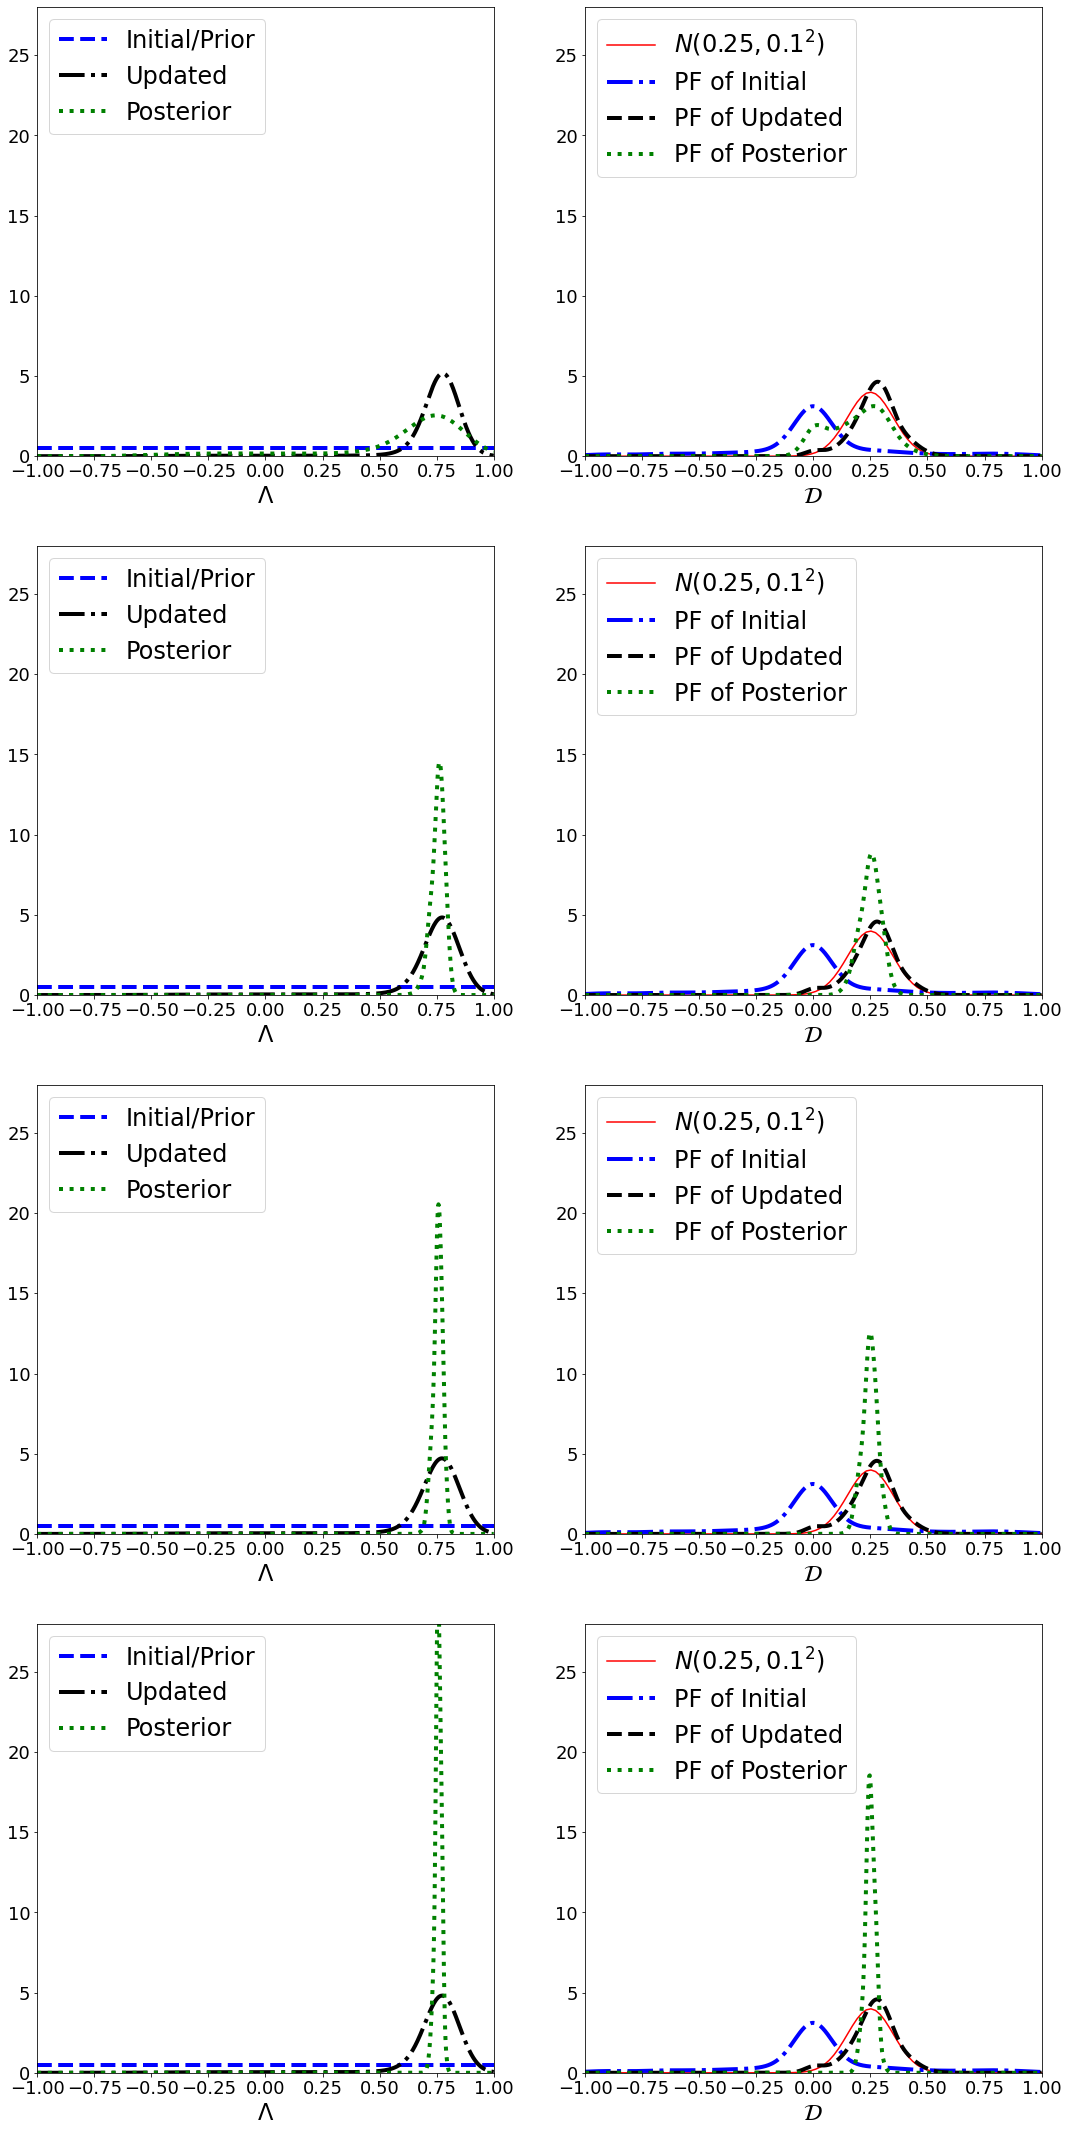

In [5]:
num_data = [1, 5, 10, 20]
fig, ax = plt.subplots(len(num_data), 2, figsize=(18, 38))

for idx, nd in enumerate(num_data):
    np.random.seed(
        123456
    )  # For reproducibility of paper results, comment out if desired.
    data = norm.rvs(loc=mu, scale=sigma**2, size=nd)

    # Construct data consistent problem object using lambda samples and QoI Values
    # Set observed to mean of observed data, with assumed std deviation of sigma
    dci = DensityProblem(lam, q_lam, domain=domain)
    dci.set_observed(norm(loc=np.mean(data), scale=sigma))
    dci.fit()

    # Construct bayesian problem object using lambda samples and QoI Values
    # Fit using observed data to construct data-likelihood
    bayes = BayesProblem(lam, q_lam, domain=domain)
    bayes.set_likelihood(norm(loc=data, scale=sigma))
    bayes.fit()

    # Parameters for initial and updated plots
    in_opts = {
        "color": "b",
        "linestyle": "--",
        "linewidth": 4,
        "label": "Initial/Prior",
    }
    up_opts = {"color": "k", "linestyle": "-.", "linewidth": 4, "label": "Updated"}
    ps_opts = {"color": "g", "linestyle": ":", "linewidth": 4, "label": "Posterior"}

    # Plot figure to created axis - note this will solve the SIP problem
    dci.plot_param_space(ax=ax[idx][0], in_opts=in_opts, up_opts=up_opts)
    bayes.plot_param_space(ax=ax[idx][0], pr_opts=None, ps_opts=ps_opts)

    # Format figure
    tick_fsize = 18
    _ = ax[idx][0].set_xlim([-1, 1])
    _ = ax[idx][0].set_ylim([0, 28])
    _ = ax[idx][0].tick_params(axis="x", labelsize=tick_fsize)
    _ = ax[idx][0].tick_params(axis="y", labelsize=tick_fsize)
    _ = ax[idx][0].set_xlabel("$\\Lambda$", fontsize=1.25 * tick_fsize)
    _ = ax[idx][0].legend(fontsize=24, loc="upper left")

    q_plot = np.linspace(-1, 1, 100)
    ax[idx][1].plot(
        q_plot, norm.pdf(q_plot, loc=mu, scale=sigma), "r-", label="$N(0.25,0.1^2)$"
    )

    # Parameters for initial and updated plots
    pr_opts = {
        "color": "b",
        "linestyle": "-.",
        "linewidth": 4,
        "label": "PF of Initial",
    }
    pf_opts = {
        "color": "k",
        "linestyle": "--",
        "linewidth": 4,
        "label": "PF of Updated",
    }
    dci.plot_obs_space(ax=ax[idx][1], pr_opts=pr_opts, pf_opts=pf_opts)

    # Comment out None to plot log likelihood
    ll_opts = (
        None  # {'color':'r', 'linestyle':'-', 'linewidth':4, 'label':'$N(0.25,0.1^2)$'}
    )
    pf_opts = {
        "color": "g",
        "linestyle": ":",
        "linewidth": 4,
        "label": "PF of Posterior",
    }

    # Plot pf of bayesian posterior
    bayes.plot_obs_space(ax=ax[idx][1], ll_opts=ll_opts, pf_opts=pf_opts)

    # Format figure
    tick_fsize = 18
    _ = ax[idx][1].set_xlim([-1, 1])
    _ = ax[idx][1].set_ylim([0, 28])
    _ = ax[idx][1].tick_params(axis="x", labelsize=tick_fsize)
    _ = ax[idx][1].tick_params(axis="y", labelsize=tick_fsize)
    _ = ax[idx][1].set_xlabel("$\\mathcal{D}$", fontsize=1.25 * tick_fsize)
    _ = ax[idx][1].legend(fontsize=24, loc="upper left")

## The Weighted Mean Error Map

TODO: Include motivation for Q_WME based off of statistica l sufficiency 

$ \Large Q_{WME,k}(\lambda) := \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{\mathcal{M}_j(\lambda) - d_{j,i}}{\sigma_j} $

## The Weighted Mean Error Map for Linear Maps

TODO: Derivation

$ \Large Q_{WME}(\lambda) = A(\mathbf{N})\lambda + b(\mathbf{N}) $ 

Where $j$th component of $\mathbf{N} \in \mathbb{R}^d$ is given by $N_j$

The $j$th row of $A(\mathbf{N})\in\mathbb{R}^{d\times p}$ by:

$ \Large A_j = \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{M_j}{\sigma_j} = \frac{N_j}{\sigma_j}M_j$

The $j$th component of $b(\mathbf{N})\in\mathbb{R}^d$ by:

$ \Large b_j(N) = - \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{d_{j,i}}{\sigma_j} $ 

### Satisfying predictability assumption
 
Since $A(\mathbf{N})\Sigma_{init}A(\mathbf{N})^T$ defines the predicted covariance, and observed covariance is the identity map for the WME map, predictabiltiy assumption is immediately satisfied if each diagonal component of the predicted covariance is significantly greater than 1. 

## Spectral Properties of Updated Covariance

In [6]:
def createRandomLinearMap(dim_input, dim_output, dist="normal", repeated=False):
    """
    Create random linear map from P dimensions to S dimensions.
    """
    if dist == "normal":
        M = np.random.randn(dim_output, dim_input)  # noqa: E221
    else:
        M = np.random.rand(dim_output, dim_input)  # noqa: E221
    if repeated:  # just use first row
        M = M[0, :].reshape(1, dim_input)

    return M


def createNoisyReferenceData(M, reference_point, std, num_data=None):
    dim_input = len(reference_point)  # noqa: E221
    if num_data is None:
        num_data = M.shape[0]
    assert (
        M.shape[1] == dim_input
    ), f"Operator/Reference dimension mismatch. op: {M.shape}, input dim: {dim_input}"
    assert (
        M.shape[0] == 1 or M.shape[0] == num_data
    ), f"Operator/Data dimension mismatch. op: {M.shape}, observations: {num_data}"
    if isinstance(std, (int, float)):  # support for std per measurement
        std = np.array([std] * num_data)  # noqa: E221
    else:
        assert (
            len(std.ravel()) == num_data
        ), f"St. Dev / Data mismatch. data: {num_data}, std: {len(std.ravel())}"

    ref_input = np.array(list(reference_point)).reshape(-1, 1)  # noqa: E221
    ref_data = M @ ref_input  # noqa: E221
    noise = np.diag(std) @ np.random.randn(num_data, 1)  # noqa: E221
    if ref_data.shape[0] == 1:
        ref_data = float(ref_data)
    data = ref_data + noise  # noqa: E221
    return data.ravel()


def createRandomLinearPair(
    reference_point, num_data, std, dist="normal", repeated=False
):
    """
    data will come from a normal distribution centered at zero
    with standard deviation given by `std`
    QoI map will come from standard uniform, or normal if dist=normal
    if `repeated` is True, the map will be rank 1.
    """
    dim_input = len(reference_point)
    M = createRandomLinearMap(dim_input, num_data, dist, repeated)  # noqa: E221, E501
    data = createNoisyReferenceData(
        M, reference_point, std, num_data
    )  # noqa: E221, E501
    return M, data


def createRandomLinearProblem(
    reference_point, num_qoi, num_observations, std_list, dist="normal", repeated=False
):
    """
    Wrapper around `createRandomLinearQoI` to generalize to multiple QoI maps.
    """
    if isinstance(std_list, (int, float)):
        std_list = [std_list] * num_qoi
    else:
        assert len(std_list) == num_qoi

    if isinstance(num_observations, (int, float)):
        num_observations = [num_observations] * num_qoi
    else:
        assert len(num_observations) == num_qoi

    assert len(std_list) == len(num_observations)
    results = [
        createRandomLinearPair(reference_point, n, s, dist, repeated)
        for n, s in zip(num_observations, std_list)
    ]
    operator_list = [r[0] for r in results]  # noqa: E221
    data_list = [r[1] for r in results]  # noqa: E221
    return operator_list, data_list, std_list


def transform_measurements(operator_list, data_list, measurements, std_list, noise):
    dim_output = len(operator_list)
    N = measurements
    _oper_list = [M[0:N, :] for M in operator_list]
    _d = np.array([y[0:N] for y in data_list]) + noise[:, 0:N]
    _data_list = _d.tolist()
    A, b = transform_linear_setup(_oper_list, _data_list, std_list)
    d = np.zeros(dim_output).reshape(-1, 1)
    return A, b, d


def transform_linear_map(operator, data, std):
    """
    Takes a linear map `operator` of size (len(data), dim_input)
    or (1, dim_input) for repeated observations, along with
    a vector `data` representing observations. It is assumed
    that `data` is formed with `M@truth + sigma` where `sigma ~ N(0, std)`

    This then transforms it to the MWE form expected by the DCI framework.
    It returns a matrix `A` of shape (1, dim_input) and np.float `b`
    and transforms it to the MWE form expected by the DCI framework.

    >>> X = np.ones((10, 2))
    >>> x = np.array([0.5, 0.5]).reshape(-1, 1)
    >>> std = 1
    >>> d = X @ x
    >>> A, b = transform_linear_map(X, d, std)
    >>> np.linalg.norm(A @ x + b)
    0.0
    >>> A, b = transform_linear_map(X, d, [std]*10)
    >>> np.linalg.norm(A @ x + b)
    0.0
    >>> A, b = transform_linear_map(np.array([[1, 1]]), d, std)
    >>> np.linalg.norm(A @ x + b)
    0.0
    >>> A, b = transform_linear_map(np.array([[1, 1]]), d, [std]*10)
    Traceback (most recent call last):
    ...
    ValueError: For repeated measurements, pass a float for std
    """
    if isinstance(data, np.ndarray):
        data = data.ravel()

    num_observations = len(data)

    if operator.shape[0] > 1:  # if not repeated observations
        assert (
            operator.shape[0] == num_observations
        ), f"Operator shape mismatch, op={operator.shape}, obs={num_observations}"
        if isinstance(std, (float, int)):
            std = np.array([std] * num_observations)
        if isinstance(std, (list, tuple)):
            std = np.array(std)
        assert len(std) == num_observations, "Standard deviation shape mismatch"
        assert 0 not in np.round(std, 14), "Std must be > 1E-14"
        D = np.diag(1.0 / (std * np.sqrt(num_observations)))
        A = np.sum(D @ operator, axis=0)
    else:
        if isinstance(std, (list, tuple, np.ndarray)):
            raise ValueError("For repeated measurements, pass a float for std")
        assert std > 1e-14, "Std must be > 1E-14"
        A = np.sqrt(num_observations) / std * operator

    b = -1.0 / np.sqrt(num_observations) * np.sum(np.divide(data, std))
    return A, b


def transform_linear_setup(operator_list, data_list, std_list):
    if isinstance(std_list, (float, int)):
        std_list = [std_list] * len(data_list)
    # repeat process for multiple quantities of interest
    results = [
        transform_linear_map(o, d, s)
        for o, d, s in zip(operator_list, data_list, std_list)
    ]
    operators = [r[0] for r in results]
    datas = [r[1] for r in results]
    return np.vstack(operators), np.vstack(datas)


def updated_cov(X, init_cov=None, data_cov=None):
    """
    We start with the posterior covariance from ridge regression
    Our matrix R = init_cov^(-1) - X.T @ pred_cov^(-1) @ X
    replaces the init_cov from the posterior covariance equation.
    Simplifying, this is given as the following, which is not used
    due to issues of numerical stability (a lot of inverse operations).

    up_cov = (X.T @ np.linalg.inv(data_cov) @ X + R )^(-1)
    up_cov = np.linalg.inv(\
        X.T@(np.linalg.inv(data_cov) - inv_pred_cov)@X + \
        np.linalg.inv(init_cov) )

    We return the updated covariance using a form of it derived
    which applies Hua's identity in order to use Woodbury's identity.

    >>> updated_cov(np.eye(2))
    array([[1., 0.],
           [0., 1.]])
    >>> updated_cov(np.eye(2)*2)
    array([[0.25, 0.  ],
           [0.  , 0.25]])
    >>> updated_cov(np.eye(3)[:, :2]*2, data_cov=np.eye(3))
    array([[0.25, 0.  ],
           [0.  , 0.25]])
    >>> updated_cov(np.eye(3)[:, :2]*2, init_cov=np.eye(2))
    array([[0.25, 0.  ],
           [0.  , 0.25]])
    """
    if init_cov is None:
        init_cov = np.eye(X.shape[1])
    else:
        assert X.shape[1] == init_cov.shape[1]

    if data_cov is None:
        data_cov = np.eye(X.shape[0])
    else:
        assert X.shape[0] == data_cov.shape[1]

    pred_cov = X @ init_cov @ X.T
    inv_pred_cov = np.linalg.pinv(pred_cov)
    # pinv b/c inv unstable for rank-deficient A

    # Form derived via Hua's identity + Woodbury
    K = init_cov @ X.T @ inv_pred_cov
    up_cov = init_cov - K @ (pred_cov - data_cov) @ K.T

    return up_cov

In [8]:
seed = 21
np.random.seed(seed)


dim_input, dim_output = 20, 5

initial_cov = np.diag(np.sort(np.random.rand(dim_input))[::-1] + 0.5)

lam_ref = np.random.randn(dim_input).reshape(-1, 1)

sigma = 1e-1
Ns = [10, 100, 1000, 10000]

operator_list, data_list, _ = createRandomLinearProblem(
    lam_ref,
    dim_output,
    [max(Ns)] * dim_output,  # want to iterate over increasing measurements
    [0] * dim_output,  # noiseless data bc we want to simulate multiple trials
    dist="norm",
    repeated=True,
)

In [17]:
operator_list

[array([[0.38681643, 0.41035418, 0.81015755, 0.60036927, 0.89834034,
         0.49003223, 0.82831813, 0.85888947, 0.78844514, 0.88765544,
         0.69886079, 0.45439031, 0.30591516, 0.8200844 , 0.13966466,
         0.4012965 , 0.23121231, 0.59045776, 0.88626806, 0.32774159]]),
 array([[0.0517916 , 0.8580917 , 0.19529546, 0.23200014, 0.52569044,
         0.45633369, 0.35097858, 0.67326352, 0.15873877, 0.05757375,
         0.35226732, 0.13085626, 0.24210468, 0.35581447, 0.31272913,
         0.63704765, 0.40061498, 0.58282751, 0.58032712, 0.26204638]]),
 array([[0.58595572, 0.90999249, 0.46397738, 0.24967199, 0.49119118,
         0.5190802 , 0.65551161, 0.46899463, 0.15865477, 0.6051533 ,
         0.39775193, 0.01055126, 0.90340573, 0.24042249, 0.12007122,
         0.42324414, 0.84578245, 0.79602254, 0.37669413, 0.72131151]]),
 array([[0.62467807, 0.87762409, 0.72045264, 0.78754428, 0.05818518,
         0.89146538, 0.09305026, 0.00535325, 0.27877188, 0.65483554,
         0.33609045, 0.47

In [38]:
UP = np.zeros((dim_input, len(Ns)))
noise_draw = np.random.randn(dim_output, max(Ns)) * sigma

for j, N in enumerate(Ns):
    A, b, _ = transform_measurements(operator_list, data_list, N, sigma, noise_draw)
    up_cov = updated_cov(A, initial_cov)
    up_sdvals = sp.linalg.svdvals(up_cov)
    UP[:, j] = up_sdvals

NameError: name 'lines' is not defined

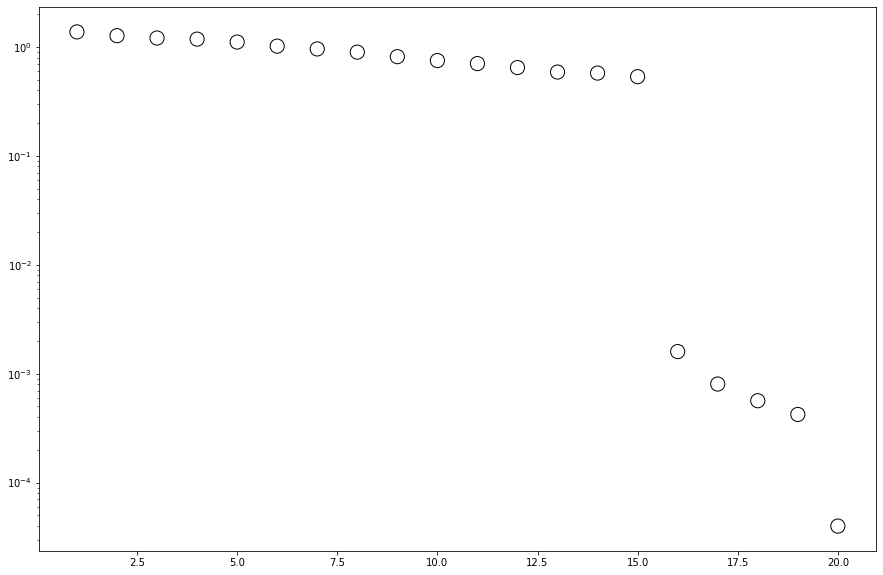

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_yscale("log")
index_values = np.arange(dim_input) + 1

for i, N in enumerate(Ns):
    ax.scatter(
        index_values,
        UP[:, i],
        marker="o",
        s=200,
        facecolors="none",
        edgecolors="k",
    )

    ax.plot(
        index_values,
        UP[:, i],
        label=f"$N={N:1.0E}$",
        alpha=1,
        lw=3,
        ls=lines[i % len(lines)],
        c="k",
    )
_ = ax.set_xticks(index_values)
_ = ax.set_xticklabels(ax.get_xticks(), rotation=0)
_ = ax.set_xlabel("Index", fontsize=fsize)
_ = ax.set_ylabel("Eigenvalue", fontsize=fsize)
_ = ax.legend(loc="lower left", fontsize=fsize * 0.75)

In [ ]:
seed = 21
np.random.seed(seed)


dim_input, dim_output = 20, 5

initial_cov = np.diag(np.sort(np.random.rand(dim_input))[::-1] + 0.5)

lam_ref = np.random.randn(dim_input).reshape(-1, 1)

sigma = 1e-1
Ns = [10, 100, 1000, 10000]

operator_list, data_list, _ = createRandomLinearProblem(
    lam_ref,
    dim_output,
    [max(Ns)] * dim_output,  # want to iterate over increasing measurements
    [0] * dim_output,  # noiseless data bc we want to simulate multiple trials
    dist="norm",
    repeated=True,
)

In [ ]:
def random_linear_map(dim_input, dim_output, dist="normal", repeated=False):
    """
    Create random linear map from P dimensions to S dimensions.
    """
    if dist == "normal":
        M = np.random.randn(dim_output, dim_input)  # noqa: E221
    else:
        M = np.random.rand(dim_output, dim_input)  # noqa: E221
    if repeated:  # just use first row
        M = M[0, :].reshape(1, dim_input)

    return M


def noisy_linear_data(
    M=None, reference_point=None, dim_input=2, dim_output=2, std, data
):
    """
    Creates data produced by model assumed to be of the form:

    Q(\lambda) = M\lambda + odj,i =Mj(λ†)+ξi, ξi ∼N(0,σj2), 1≤i≤Nj

    Parameters
    ----------

    Returns
    -------

    """
    dim_
    dim_input = len(reference_point)

    if num_data is None:
        num_data = M.shape[0]
    assert (
        M.shape[1] == dim_input
    ), f"Operator/Reference dimension mismatch. op: {M.shape}, input dim: {dim_input}"
    assert (
        M.shape[0] == 1 or M.shape[0] == num_data
    ), f"Operator/Data dimension mismatch. op: {M.shape}, observations: {num_data}"
    if isinstance(std, (int, float)):  # support for std per measurement
        std = np.array([std] * num_data)  # noqa: E221
    else:
        assert (
            len(std.ravel()) == num_data
        ), f"St. Dev / Data mismatch. data: {num_data}, std: {len(std.ravel())}"

    ref_input = np.array(list(reference_point)).reshape(-1, 1)  # noqa: E221
    ref_data = M @ ref_input  # noqa: E221
    noise = np.diag(std) @ np.random.randn(num_data, 1)  # noqa: E221
    if ref_data.shape[0] == 1:
        ref_data = float(ref_data)
    data = ref_data + noise  # noqa: E221
    return data.ravel()


def createRandomLinearPair(
    reference_point, num_data, std, dist="normal", repeated=False
):
    """
    data will come from a normal distribution centered at zero
    with standard deviation given by `std`
    QoI map will come from standard uniform, or normal if dist=normal
    if `repeated` is True, the map will be rank 1.
    """
    dim_input = len(reference_point)

    M = createRandomLinearMap(dim_input, num_data, dist, repeated)  # noqa: E221, E501

    if dist == "normal":
        M = np.random.randn(dim_output, dim_input)  # noqa: E221
    else:
        M = np.random.rand(dim_output, dim_input)  # noqa: E221
    if repeated:  # just use first row
        M = M[0, :].reshape(1, dim_input)

    return M

    data = createNoisyReferenceData(
        M, reference_point, std, num_data
    )  # noqa: E221, E501
    return M, data


def random_linear_problem(
    reference_point,
    dist="nomral",
    num_qoi=1,
    num_observations=10,
    std,
    dist="normal",
    repeated=False,
):
    """
    Create a random linear

    Parameters
    ----------
    reference_point : ndarray
        Reference true parameter value.
    dist: str, default='normal'
        Distribution to draw random linear map from. 'normal' or 'uniform' supported at the moment.
    num_qoi : int, default = 1
        Number of QoI
    num_observations: int, default = 10
        Number of observation data points.
    std_dev: ndarray, optional
        Standard deviation of normal distribution from where observed data points are drawn from.
        If none specified, noise-less data is created.

    Returns
    -------


    """
    if isinstance(std_list, (int, float)):
        std_list = [std_list] * num_qoi
    else:
        assert len(std_list) == num_qoi

    if isinstance(num_observations, (int, float)):
        num_observations = [num_observations] * num_qoi
    else:
        assert len(num_observations) == num_qoi

    assert len(std_list) == len(num_observations)
    results = [
        createRandomLinearPair(reference_point, n, s, dist, repeated)
        for n, s in zip(num_observations, std_list)
    ]
    operator_list = [r[0] for r in results]  # noqa: E221
    data_list = [r[1] for r in results]  # noqa: E221
    return operator_list, data_list, std_list

In [14]:
dim_input = 5
dim_output = 5
repeated = False

if dist == "normal":
    M = np.random.randn(dim_output, dim_input)  # noqa: E221
else:
    M = np.random.rand(dim_output, dim_input)  # noqa: E221
if repeated:  # just use first row
    M = M[0, :].reshape(1, dim_input)

M

array([[0.35863985, 0.32446768, 0.45202807, 0.39970752, 0.65653057],
       [0.49470331, 0.88344216, 0.7539208 , 0.89099436, 0.47231454],
       [0.23907864, 0.02531939, 0.50385347, 0.85149614, 0.44378779],
       [0.36661544, 0.1067954 , 0.19398938, 0.18424889, 0.98328237],
       [0.17180107, 0.20781072, 0.8965399 , 0.77355275, 0.39249917]])